<h1 style="text-align:center">Defense Terrain Intelligence through CNN-Based Satellite Imagery Classification</h1>
<h5 style='text-align: center'><a href='https://github.com/sohamkhanna08'>Soham Khanna</a></h5>

Table of contents
1. [Introduction](#1)
2. [Data preprocessing](#2)
3. [Model building](#3)
4. [Model training](#4)
5. [Model evaluation](#5)
6. [Optimizing model performance](#6)
7. [Predictions](#7)
8. [Conclusions](#8)

<h2 style="text-align:center">Introduction <a class="anchor" id="1"></a></h2>

Satellite image classification plays a crucial role in a wide range of applications, including precision agriculture, urban planning, natural resource management, and disaster response. With the increasing availability of satellite data, developing accurate and efficient methods for automatically interpreting these images has become essential.

In this notebook, It is demonstrated how to classify satellite images using a custom neural network architecture named SpectrumNet. The dataset used is the "EuroSAT" dataset, which comprises 27,000 labeled images of land use and land cover. The images are categorized into 10 distinct classes: AnnualCrop, Forest, HerbaceousVegetation, Highway, Industrial, Pasture, PermanentCrop, Residential, River, and SeaLake.

The objective of this project is to build a neural network capable of accurately classifying these images into the correct classes. Finally, try to divide an image into 64x64 patches and classify each patch using the model to create a complete classification map.


<div style='justify-content: center; display: flex;'>
    <img src='Resources/Satellite Image Classification.png' width='70%'/>
</div>

<h2 style="text-align:center">Data preprocessing <a class="anchor" id = "2"></a></h2>

<h3>Importing libraries and downloading dataset</h3>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools, math
import os
import kagglehub
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, Activation, BatchNormalization, MaxPooling2D, AveragePooling2D, Flatten, Concatenate)
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler, Callback

#Download Dataset
path = kagglehub.dataset_download("apollo2506/eurosat-dataset")
print("Dataset downloaded to:", path)

<h3>Train, validation, and test datasets</h3>

In [ ]:
IMG_SIZE = 64
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

base_path = "/root/.cache/kagglehub/datasets/apollo2506/eurosat-dataset/versions/6/EuroSAT"

train_csv = pd.read_csv(os.path.join(base_path, "train.csv"))
validation_csv = pd.read_csv(os.path.join(base_path, "validation.csv"))
test_csv = pd.read_csv(os.path.join(base_path, "test.csv"))


def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = image / 255.0
    return image

def augment(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = tf.image.random_saturation(image, lower=0.9, upper=1.1)
    return image

def create_dataset_from_dataframe(df, base_dir, num_classes, augment_data=False):
    image_paths = df['Filename'].apply(lambda x: os.path.join(base_dir, x)).tolist()
    labels = df['Label'].tolist()

    labels = tf.keras.utils.to_categorical(labels, num_classes)

    ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    ds = ds.map(lambda x, y: (load_and_preprocess_image(x), y), num_parallel_calls=AUTOTUNE)
    if augment_data:
        ds = ds.map(lambda x, y: (augment(x), y), num_parallel_calls=AUTOTUNE)
    ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = create_dataset_from_dataframe(train_csv, base_path, num_classes=10, augment_data=True)
validation_ds = create_dataset_from_dataframe(validation_csv, base_path, num_classes=10)
test_ds = create_dataset_from_dataframe(test_csv, base_path, num_classes=10)


<h3>Data sample visualization</h3>

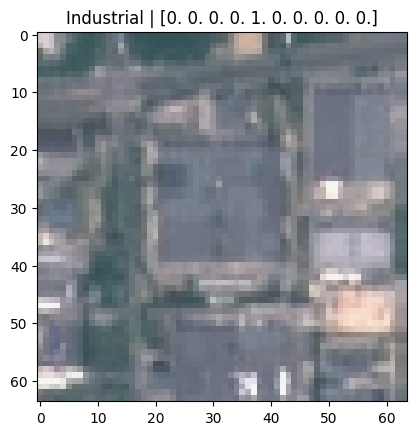

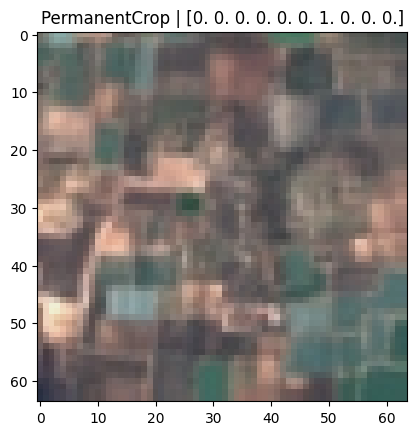

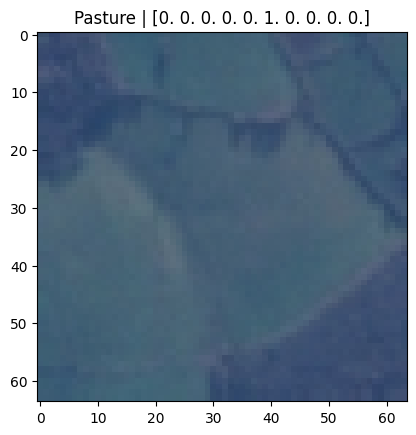

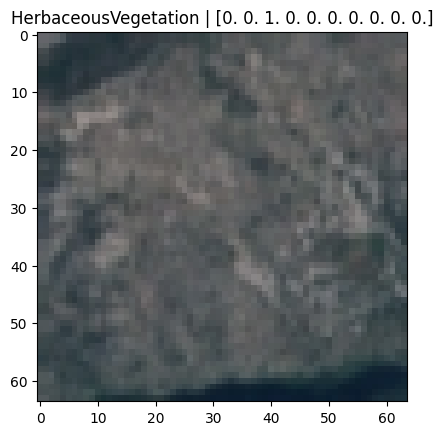

In [4]:
data_sample = train_ds.as_numpy_iterator()
res = data_sample.next()

classNamesLabels = {
    0: 'AnnualCrop',
    1: 'Forest',
    2: 'HerbaceousVegetation',
    3: 'Highway',
    4: 'Industrial',
    5: 'Pasture',
    6: 'PermanentCrop',
    7: 'Residential',
    8: 'River',
    9: 'SeaLake'
}

for idx in range(4):
    Image = np.clip(res[0][idx], 0, 1) 
    Label = res[1][idx]
    plt.figure()
    plt.imshow(Image)
    plt.title(f"{classNamesLabels[np.argmax(Label)]} | {Label}")
    plt.show()

<h2 style="text-align:center">Model building <a class="anchor" id = "3"></a></h2>
<p style="text-align:center">Convolutional Neural Network (CNN).</p>

In [5]:
def spectral_block(X, filters, stage, s=1):
    squeeze_base_name = 'squeeze_' + str(stage) + '_branch'
    bn_base_name = 'bn_' + str(stage) + "_branch"
    
    F1, F2, F3 = filters
    
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='same', name=squeeze_base_name + 'a')(X)
    
    X_11 = Conv2D(filters=F2, kernel_size=(1, 1), strides=(s, s), padding='same', name=squeeze_base_name + 'b')(X)
    X_33 = Conv2D(filters=F3, kernel_size=(3, 3), strides=(s, s), padding='same', name=squeeze_base_name + 'c')(X)
    
    X = Concatenate(name="concatenate_" + str(stage))([X_11, X_33])
    X = BatchNormalization(name=bn_base_name)(X)
    X = Activation("relu", name="spectral" + str(stage))(X)
    
    return X

def SpectrumNet(input_shape, classes):
    X_input = Input(input_shape, name="input")
    
    X = Conv2D(96, (1, 1), strides=(2, 2), name='conv1', padding="same")(X_input)
    
    X = spectral_block(X, [16, 96, 32], 2)
    X = spectral_block(X, [16, 96, 32], 3)
    X = spectral_block(X, [32, 192, 64], 4)
    
    X = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same", name="maxpool4")(X)
    
    X = spectral_block(X, [32, 192, 64], 5)
    X = spectral_block(X, [48, 288, 96], 6)
    X = spectral_block(X, [48, 288, 96], 7)
    X = spectral_block(X, [64, 384, 128], 8)
    
    X = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same", name="maxpool8")(X)
    
    X = spectral_block(X, [64, 384, 128], 9)
    
    X = Conv2D(classes, kernel_size=(1, 1), strides=(1, 1), name="conv10", padding='same')(X)
    X = BatchNormalization(name="conv10_batchnormalisation")(X)
    X = Activation("relu", name="conv10_activation")(X)
    
    X = AveragePooling2D(pool_size=(8, 8), strides=(1, 1), name="avgpool10")(X)
    
    X = Flatten(name="flatten10")(X)
    X = Activation("softmax", name="output")(X)
    
    model = Model(inputs=X_input, outputs=X, name="SpectrumNet")
    
    return model

In [6]:
model = SpectrumNet(input_shape=(IMG_SIZE, IMG_SIZE, 3), classes=10)

model.summary()

Model: "SpectrumNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 64, 64, 3) │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 32, 32,    │        384 │ input[0][0]       │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ squeeze_2_brancha   │ (None, 32, 32,    │      1,552 │ conv1[0][0]       │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ squeeze_2_branchb   │ (None, 32, 32,    │      1,632 │ squeeze_2_branch… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ squeeze_2_branchc   │ (None, 32, 32,    │      4,640 │ squeeze_2_branch… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 32, 32,    │          0 │ squeeze_2_branch… │
│ (Concatenate)       │ 128)              │            │ squeeze_2_branch… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_2_branch         │ (None, 32, 32,    │        512 │ concatenate_2[0]… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spectral2           │ (None, 32, 32,    │          0 │ bn_2_branch[0][0] │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ squeeze_3_brancha   │ (None, 32, 32,    │      2,064 │ spectral2[0][0]   │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ squeeze_3_branchb   │ (None, 32, 32,    │      1,632 │ squeeze_3_branch… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ squeeze_3_branchc   │ (None, 32, 32,    │      4,640 │ squeeze_3_branch… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 32, 32,    │          0 │ squeeze_3_branch… │
│ (Concatenate)       │ 128)              │            │ squeeze_3_branch… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_3_branch         │ (None, 32, 32,    │        512 │ concatenate_3[0]… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spectral3           │ (None, 32, 32,    │          0 │ bn_3_branch[0][0] │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ squeeze_4_brancha   │ (None, 32, 32,    │      4,128 │ spectral3[0][0]   │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ squeeze_4_branchb   │ (None, 32, 32,    │      6,336 │ squeeze_4_branch… │
│ (Conv2D)            │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ squeeze_4_branchc   │ (None, 32, 32,    │     18,496 │ squeeze_4_branch… │
│ (Conv2D)            │ 64)               │            │                 

 Total params: 491,250 (1.87 MB)

 Trainable params: 486,110 (1.85 MB)

 Non-trainable params: 5,140 (20.08 KB)

<h2 style="text-align:center">Model training <a class="anchor" id = "4"></a></h2>

<h3>Auxiliary functions</h3>

In [7]:
def compute_class_weights(labels, num_classes):
    class_totals = np.bincount(labels, minlength=num_classes)
    class_weights = {i: class_totals.max() / class_totals[i] for i in range(num_classes)}
    return class_weights

def show_final_history(history):
    plt.style.use("ggplot")
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')
    
    ax[0].plot(history.history['loss'], 'r-', label='Training Loss')
    ax[0].plot(history.history['val_loss'], 'g-', label='Validation Loss')
    ax[1].plot(history.history['categorical_accuracy'], 'r-', label='Training Accuracy')
    ax[1].plot(history.history['val_categorical_accuracy'], 'g-', label='Validation Accuracy')
    
    ax[0].legend(loc='upper right')
    ax[1].legend(loc='lower right')
    
    plt.show()

def plot_learning_rate(loss_history):
    plt.style.use("ggplot")
    plt.plot(np.arange(0, len(loss_history.lr)), loss_history.lr)
    plt.show()

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f'
    thresh = cm.max() / 2.0
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
    
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.grid(False)
    plt.show()

def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lrate

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(step_decay(len(self.losses)))

<h3>Training</h3>

Epoch 1/50
  5/591 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - categorical_accuracy: 0.1255 - loss: 2.5743 

I0000 00:00:1722748400.029574     110 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - categorical_accuracy: 0.5249 - loss: 1.8072
Epoch 1: val_categorical_accuracy improved from -inf to 0.57241, saving model to satelliteImageClassifierWeights.keras
591/591 ━━━━━━━━━━━━━━━━━━━━ 63s 61ms/step - categorical_accuracy: 0.5250 - loss: 1.8067 - val_categorical_accuracy: 0.5724 - val_loss: 1.4008 - learning_rate: 0.0010
Epoch 2/50
590/591 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.7178 - loss: 1.1736
Epoch 2: val_categorical_accuracy did not improve from 0.57241
591/591 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - categorical_accuracy: 0.7178 - loss: 1.1734 - val_categorical_accuracy: 0.5420 - val_loss: 1.5943 - learning_rate: 0.0010
Epoch 3/50
590/591 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.7545 - loss: 0.9902
Epoch 3: val_categorical_accuracy improved from 0.57241 to 0.76481, saving model to satelliteImageClassifierWeights.keras
591/591 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - categorical_accuracy: 0.7545 - 

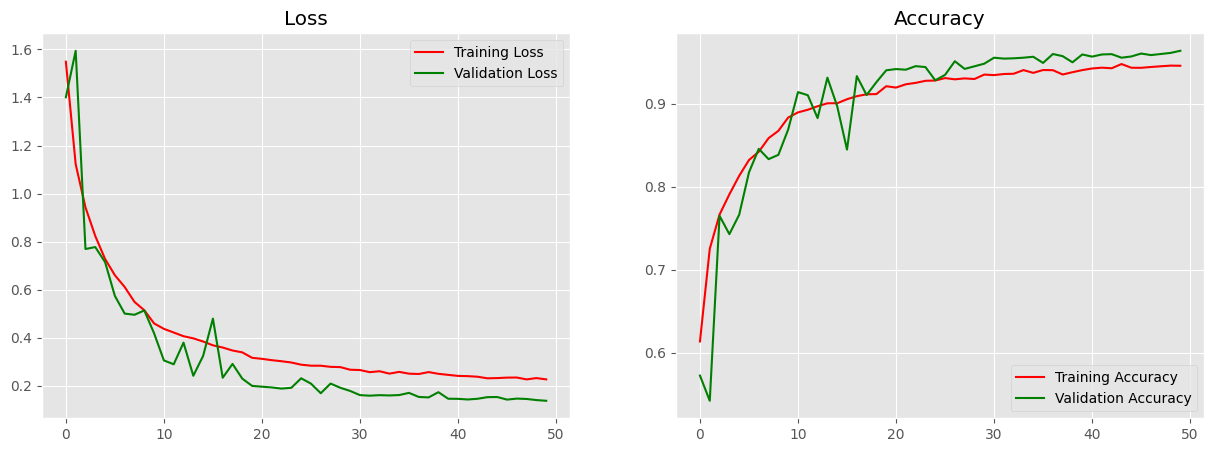

In [8]:
train_labels = train_csv['Label'].to_numpy()
class_weights = compute_class_weights(train_labels, num_classes=10)

checkpoint = ModelCheckpoint("satelliteImageClassifierWeights.keras", monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
logs = TensorBoard(log_dir="logs", histogram_freq=1)

loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay)

opt = SGD(learning_rate=1e-4, momentum=0.9, nesterov=True)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

epochs = 50
batchSize = 32
history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=validation_ds,
                    callbacks=[checkpoint, lrate, loss_history],
                    class_weight=class_weights)

show_final_history(history)

<h3>Saving the model</h3>

In [9]:
model.save('Satellite_Image_Classifier_Model.keras')
print("Model saved successfully.")
model.save_weights('.weights.h5')
print("Model weights saved successfully.")

Model saved successfully.
Model weights saved successfully.


<h2 style="text-align:center">Model evaluation <a class="anchor" id = "5"></a></h2>
<p style="text-align:center">The model will be evaluated using the test dataset.</p>

85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - categorical_accuracy: 0.9643 - loss: 0.1231
Test loss: 0.1263754814863205
Test accuracy: 0.9629629850387573
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step


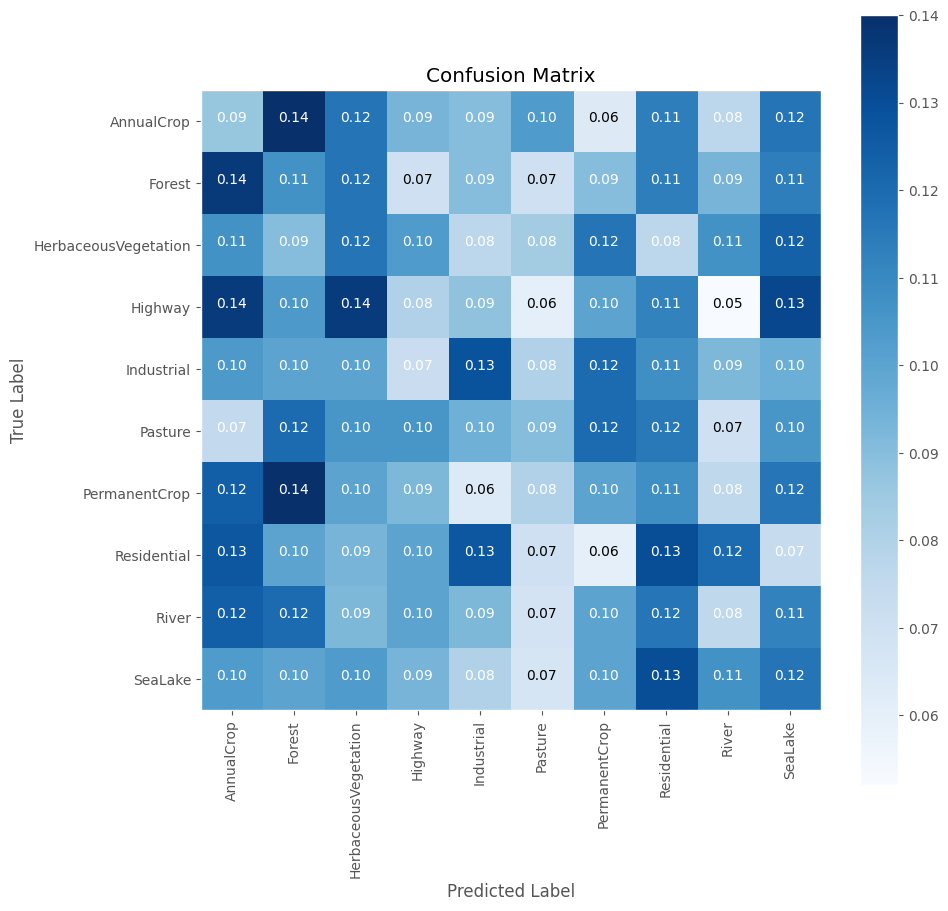

In [10]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

test_predictions = model.predict(test_ds)
test_pred_labels = np.argmax(test_predictions, axis=1)

test_true_labels = np.concatenate([y.numpy() for x, y in test_ds], axis=0)

test_true_labels = np.argmax(test_true_labels, axis=1)

cm = confusion_matrix(test_true_labels, test_pred_labels)

class_names = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
               'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

plot_confusion_matrix(cm, classes=class_names, title='Confusion Matrix')

<h2 style="text-align:center">Optimizing model performance <a class="anchor" id = "6"></a></h2>

<p>To optimize the model performance, three versions of training were conducted with variations in the step_decay parameters. Each version aimed to identify the best learning rate schedule for optimal model accuracy and generalization.</p>

<table style="width:100%; border: 1px solid black; border-collapse: collapse; text-align: center;">
  <thead style="border: 1px solid black; padding: 8px;">
    <tr>
      <th style="border: 1px solid black; padding: 8px;">Version</th>
      <th style="border: 1px solid black; padding: 8px;">Initial Learning Rate</th>
      <th style="border: 1px solid black; padding: 8px;">Drop</th>
      <th style="border: 1px solid black; padding: 8px;">Epochs Drop</th>
      <th style="border: 1px solid black; padding: 8px;">Optimizer</th>
      <th style="border: 1px solid black; padding: 8px;">Best Model (Epochs)</th>
      <th style="border: 1px solid black; padding: 8px;">Training Accuracy</th>
      <th style="border: 1px solid black; padding: 8px;">Test Loss</th>
      <th style="border: 1px solid black; padding: 8px;">Test Accuracy</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="border: 1px solid black; padding: 8px;">Version 1</td>
      <td style="border: 1px solid black; padding: 8px;">0.0005</td>
      <td style="border: 1px solid black; padding: 8px;">0.5</td>
      <td style="border: 1px solid black; padding: 8px;">20.0</td>
      <td style="border: 1px solid black; padding: 8px;">SGD (1e-4, 0.9, True)</td>
      <td style="border: 1px solid black; padding: 8px;">70</td>
      <td style="border: 1px solid black; padding: 8px;">95.41%</td>
      <td style="border: 1px solid black; padding: 8px;">0.1449</td>
      <td style="border: 1px solid black; padding: 8px;">95.74%</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 8px;">Version 2</td>
      <td style="border: 1px solid black; padding: 8px;">0.001</td>
      <td style="border: 1px solid black; padding: 8px;">0.5</td>
      <td style="border: 1px solid black; padding: 8px;">10.0</td>
      <td style="border: 1px solid black; padding: 8px;">SGD (1e-4, 0.9, True)</td>
      <td style="border: 1px solid black; padding: 8px;">50</td>
      <td style="border: 1px solid black; padding: 8px;">97.09%</td>
      <td style="border: 1px solid black; padding: 8px;">0.1364</td>
      <td style="border: 1px solid black; padding: 8px;">96.33%</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 8px;">Version 3</td>
      <td style="border: 1px solid black; padding: 8px;">0.001</td>
      <td style="border: 1px solid black; padding: 8px;">0.1</td>
      <td style="border: 1px solid black; padding: 8px;">30.0</td>
      <td style="border: 1px solid black; padding: 8px;">SGD (1e-4, 0.9, True)</td>
      <td style="border: 1px solid black; padding: 8px;">50</td>
      <td style="border: 1px solid black; padding: 8px;">97.06%</td>
      <td style="border: 1px solid black; padding: 8px;">0.1062</td>
      <td style="border: 1px solid black; padding: 8px;">96.93%</td>
    </tr>
  </tbody>
</table>

<h3 style="text-align:center">Confusion matrix analysis</h2>

<p>The confusion matrices for the best models of each version show the detailed performance across the 10 classes. The matrices provide insights into the specific classes that the models struggled to classify correctly, allowing for targeted improvements.</p>

<div style='justify-content: center; display: flex;'>
  <div>
    <img src='Models/Version1/ConfusionMatrices/confusionMatrix70Epochs.png' width='100%'/>
    <p style='text-align: center'>Confusion matrix version 1</p>
  </div>
  <div>
    <img src='Models/Version2/ConfusionMatrices/confusionMatrix50Epochs.png' width='100%'/>
    <p style='text-align: center'>Confusion matrix version 2</p>
  </div>
  <div>
    <img src='Models/Version3/ConfusionMatrices/confusionMatrix50Epochs3.png' width='100%'/>
    <p style='text-align: center'>Confusion matrix version 3</p>
  </div>
</div>

<h3 style="text-align:center">Loss and accuracy curves</h3>

<p>The training and validation loss and accuracy curves for the best models in each version show how the model's performance evolved over epochs. The curves help identify overfitting, underfitting, and the stability of the learning process.</p>

<div style='justify-content: center; display: flex;'>
  <div>
    <img src='Models/Version1/Curves/train_70Epochs.png' width='100%'/>
    <p style='text-align: center'>Loss and accuracy curves version 1</p>
  </div>
  <div>
    <img src='Models/Version2/Curves/train_50Epochs.png' width='100%'/>
    <p style='text-align: center'>Loss and accuracy curves version 2</p>
  </div>
  <div>
    <img src='Models/Version3/Curves/train_50Epochs3.png' width='100%'/>
    <p style='text-align: center'>Loss and accuracy curves version 3</p>
  </div>
</div>

<h2 style="text-align:center">Predictions <a class="anchor" id = "7"></a></h2>

<div style='text-align: center'>
    <img src='Resources/classes/AnnualCrop.jpg'/>
    <img src='Resources/classes/Forest.jpg'/>
    <img src='Resources/classes/HerbaceousVegetation.jpg'/>
    <img src='Resources/classes/Highway.jpg'/>
    <img src='Resources/classes/Industrial.jpg'/>
    <img src='Resources/classes/Pasture.jpg'/>
    <img src='Resources/classes/PermanentCrop.jpg'/>
    <img src='Resources/classes/Residential.jpg'/>
    <img src='Resources/classes/River.jpg'/>
    <img src='Resources/classes/SeaLake.jpg'/>
</div>
<div style='justify-content: center; display: flex;'>
    <img src="Resources/labels.png" width=57%/>
</div>

<p style="text-align:center">Labels</p>

64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step


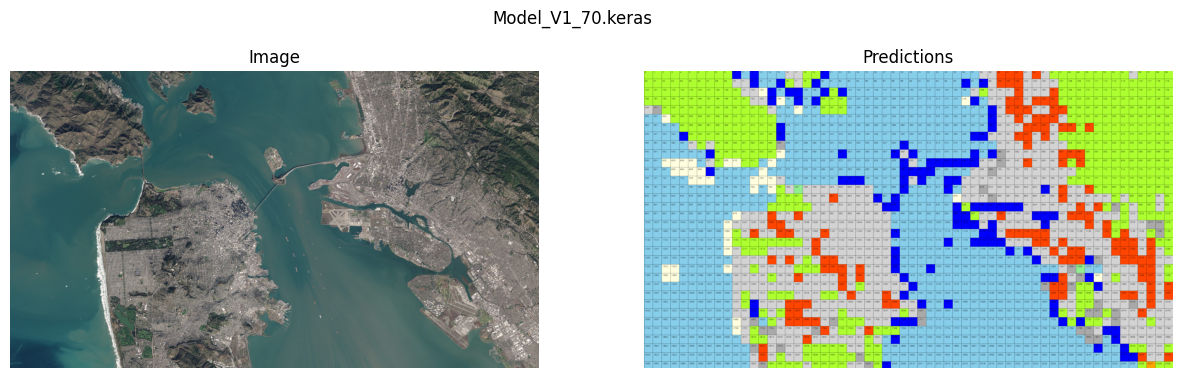

64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step


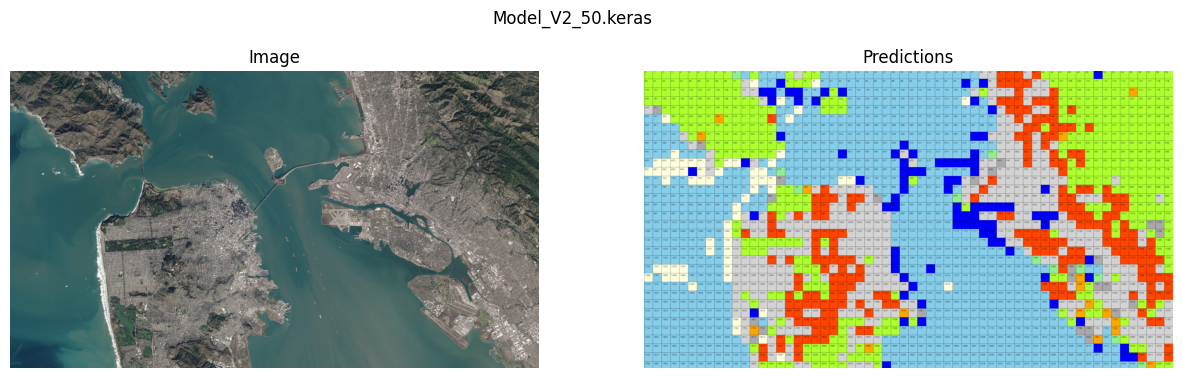

64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step


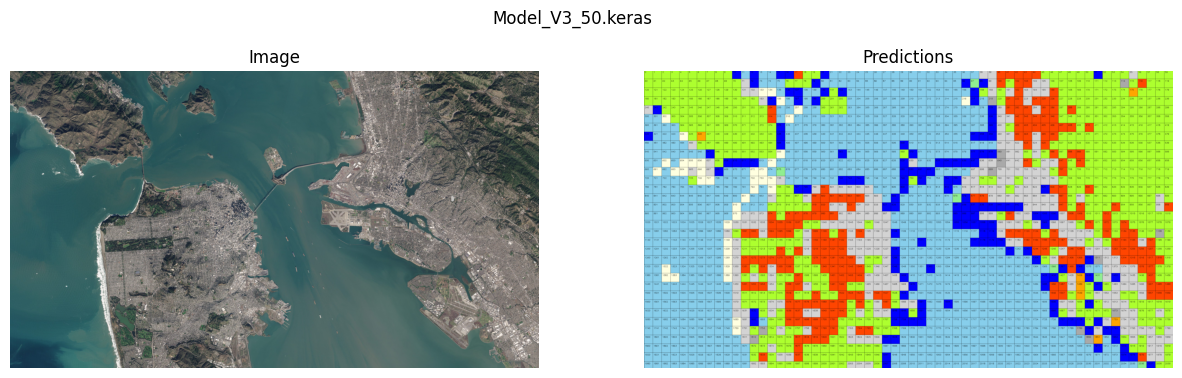

In [1]:
from classifier import SatelliteImageClassification

image = 'Images/5.jpg'

classifierV150I5 = SatelliteImageClassification()
classifierV150I5.load_model_SIC('Models/Version1/Model_V1_70.keras')
original_image, colored_image = classifierV150I5.process_image(image)
classifierV150I5.plot_images(original_image, colored_image)

classifierV250I5 = SatelliteImageClassification()
classifierV250I5.load_model_SIC('Models/Version2/Model_V2_50.keras')
original_image, colored_image = classifierV250I5.process_image(image)
classifierV250I5.plot_images(original_image, colored_image)

classifierV350I5 = SatelliteImageClassification()
classifierV350I5.load_model_SIC('Models/Version3/Model_V3_50.keras')
original_image, colored_image = classifierV350I5.process_image(image)
classifierV350I5.plot_images(original_image, colored_image)

34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step


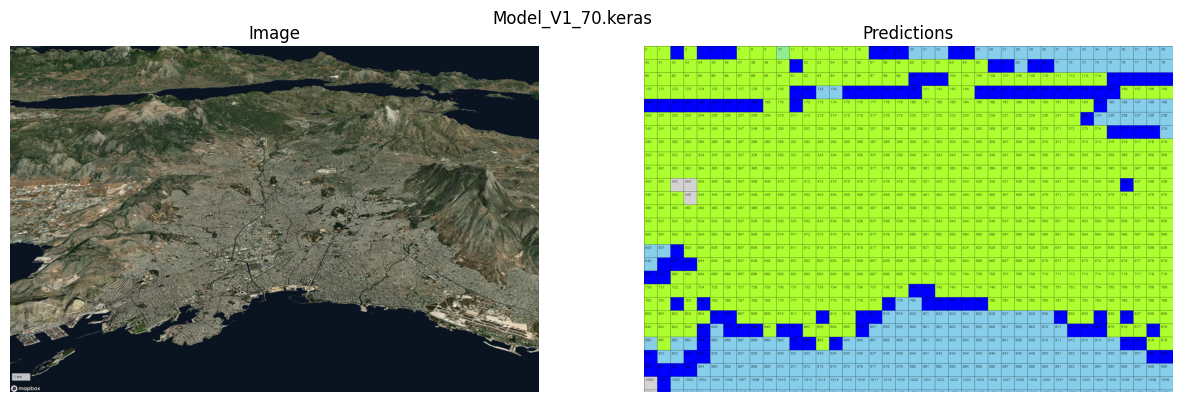

34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step


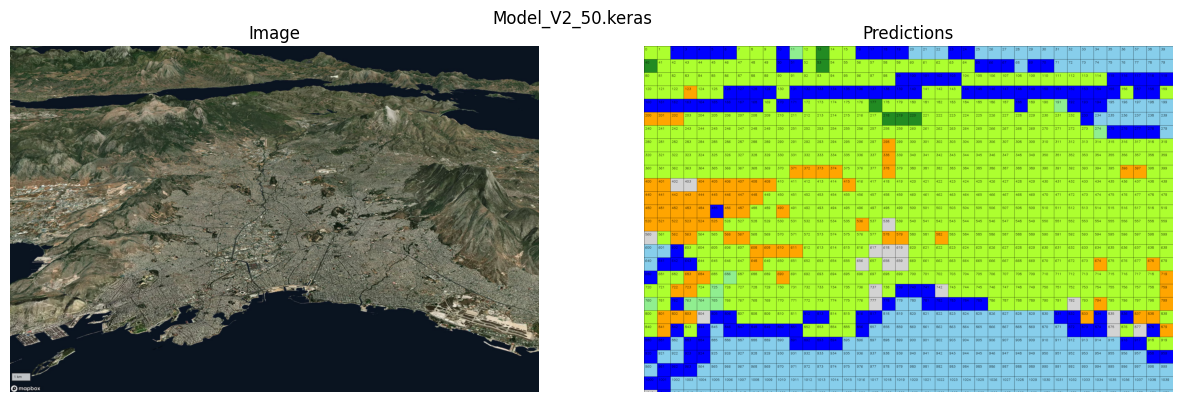

34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step


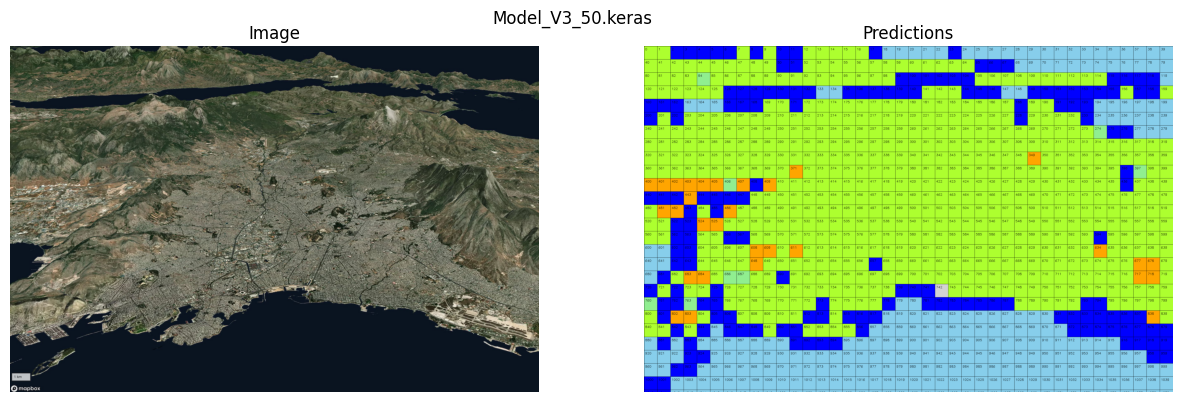

In [2]:
image = 'Images/14.jpeg'

classifierV150I14 = SatelliteImageClassification()
classifierV150I14.load_model_SIC('Models/Version1/Model_V1_70.keras')
original_image, colored_image = classifierV150I14.process_image(image)
classifierV150I14.plot_images(original_image, colored_image)

classifierV250I14 = SatelliteImageClassification()
classifierV250I14.load_model_SIC('Models/Version2/Model_V2_50.keras')
original_image, colored_image = classifierV250I14.process_image(image)
classifierV250I14.plot_images(original_image, colored_image)

classifierV350I14 = SatelliteImageClassification()
classifierV350I14.load_model_SIC('Models/Version3/Model_V3_50.keras')
original_image, colored_image = classifierV350I14.process_image(image)
classifierV350I14.plot_images(original_image, colored_image)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step


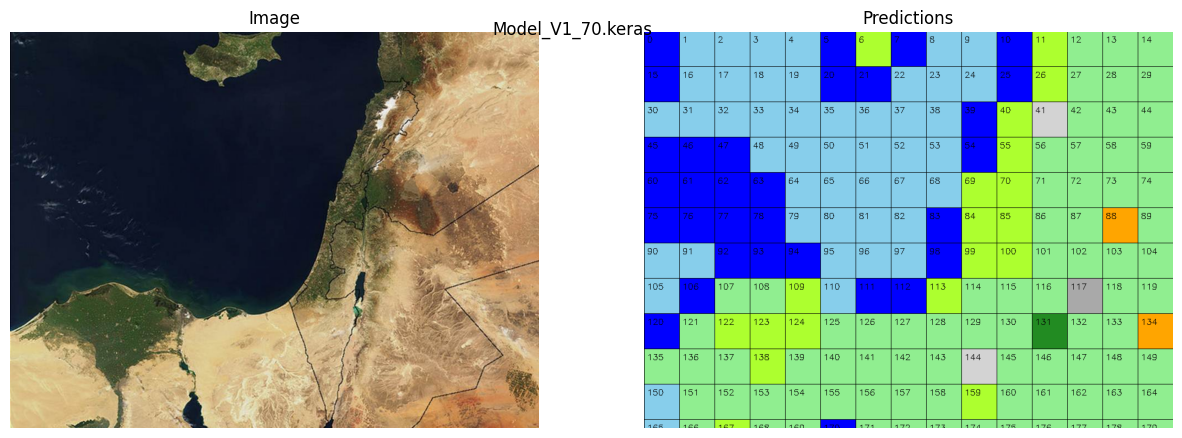

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step


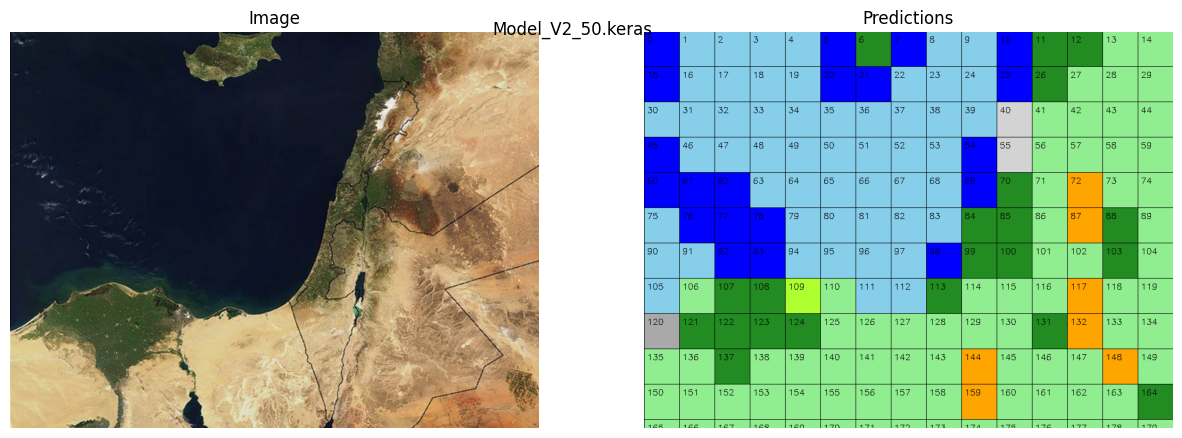

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step


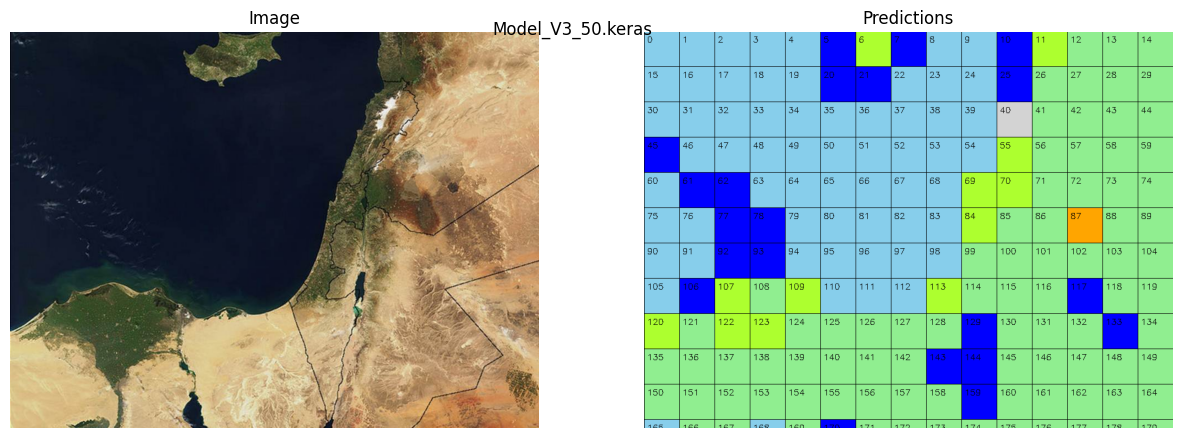

In [3]:
image = 'Images/1.jpeg'

classifierV150I1 = SatelliteImageClassification()
classifierV150I1.load_model_SIC('Models/Version1/Model_V1_70.keras')
original_image, colored_image = classifierV150I1.process_image(image)
classifierV150I1.plot_images(original_image, colored_image)

classifierV250I1 = SatelliteImageClassification()
classifierV250I1.load_model_SIC('Models/Version2/Model_V2_50.keras')
original_image, colored_image = classifierV250I1.process_image(image)
classifierV250I1.plot_images(original_image, colored_image)

classifierV350I1 = SatelliteImageClassification()
classifierV350I1.load_model_SIC('Models/Version3/Model_V3_50.keras')
original_image, colored_image = classifierV350I1.process_image(image)
classifierV350I1.plot_images(original_image, colored_image)

<h2 style="text-align:center">Conclusions<a class="anchor" id = "8"></a></h2>

<p>This study explored different configurations of model training to evaluate the performance of a neural network for satellite image classification. By experimenting with various configurations and adjusting the number of epochs, the optimal number of epochs that produced the best results for each version was identified. This methodical approach allowed for pinpointing the most effective models from each training version. Comparative analysis of these models revealed that Version 2 outperformed the others in class prediction accuracy. Consequently, it was determined that Version 2 was the most efficient model for classifying satellite images.</p>

<p>The quality of the dataset significantly impacted these outcomes. The images used in the dataset are 64x64 pixels, and higher resolution images could potentially enhance classification accuracy. Furthermore, implementing a more sophisticated convolutional neural network architecture could significantly improve results, leading to even better classification performance.</p>

<p>In summary, this project underscores the potential of convolutional neural networks in satellite image classification. It emphasizes the importance of careful model configuration, high-quality data, and the selection of appropriate network architectures to achieve superior classification accuracy. The findings of this study contribute valuable insights into the development and optimization of neural network models for remote sensing applications.</p>